In [1]:
%pip install optuna  

Note: you may need to restart the kernel to use updated packages.



# Dynamic Trip Rescheduling System #

A cleaned and optimized notebook for multi-objective optimization of disrupted logistics trips.
 
 **Key improvements in this version:**
 - Reduced verbose output - only showing best candidates
 - Proper visualization integration
 - Fixed driver state and deadhead calculations
- Organized code structure with clear sections



  0%|          | 0/20 [00:00<?, ?it/s]

🚛 DYNAMIC TRIP RESCHEDULING SYSTEM

📊 Loading Data...
✅ Loaded 14,817 trips across 1,504 routes
📅 Date range: 2018-09-12 to 2018-10-04

🔧 Initializing Driver States...
✅ Initialized 20 driver states (reduced for demo)
💡 Fewer drivers = more competition = tradeoffs for BO to optimize
📊 System utilization: 0.0%

📍 Loading Distance Matrix...
✅ Loaded distance matrix: (1319, 1319)
✅ Number of locations: 1319
📊 Average travel time: 2841.4 minutes

🔧 Fixing Location Mapping...

🔥 Creating Disruption Scenario...
📊 Creating challenging scenario for BO demonstration:
  Total trips available: 14817
  Medium duration trips (2-5h): 5112

✅ Selected 30 disrupted trips
📊 Scenario characteristics:
  Average duration: 3.2 hours
  Unique source locations: 30
  Unique destinations: 29
  Trips: 30 vs Drivers: 20
  Duration range: 2.0 - 4.6 hours

💡 Why this creates optimization opportunities:
   • More trips (30) than drivers (20)
   • Geographic dispersion forces deadhead travel
   • Medium durations cr

Best trial: 0. Best value: inf: 100%|██████████| 20/20 [00:00<00:00, 31.54it/s]


✅ Optimization complete!

📊 Best parameters found by BO:
  Cost weight: 13.67%
  Service weight: 86.33%
  Max cascade depth: 3
  Max deadhead: 37 min
  Max delay: 167 min

🚀 Running CP-SAT with BO-optimized parameters...
   Compliance enforced as hard constraints

🚀 Starting optimization for 30 disrupted trips
   Compliance enforced as HARD CONSTRAINTS
   Optimizing: Cost vs Service Quality

📋 Generating candidates...
  Trip trip-153858871248292741: 20 candidates
  Trip trip-153679914398648278: 20 candidates
  Trip trip-153763533736487541: 20 candidates
  Trip trip-153783320311132940: 20 candidates
  Trip trip-153809604890113789: 20 candidates
  Trip trip-153800081587061798: 20 candidates
  Trip trip-153671042288605164: 20 candidates
  Trip trip-153784617754038393: 20 candidates
  Trip trip-153676308640655880: 20 candidates
  Trip trip-153827517431934159: 20 candidates
  Trip trip-153843730942915459: 20 candidates
  Trip trip-153800232371022052: 20 candidates
  Trip trip-15369014599078

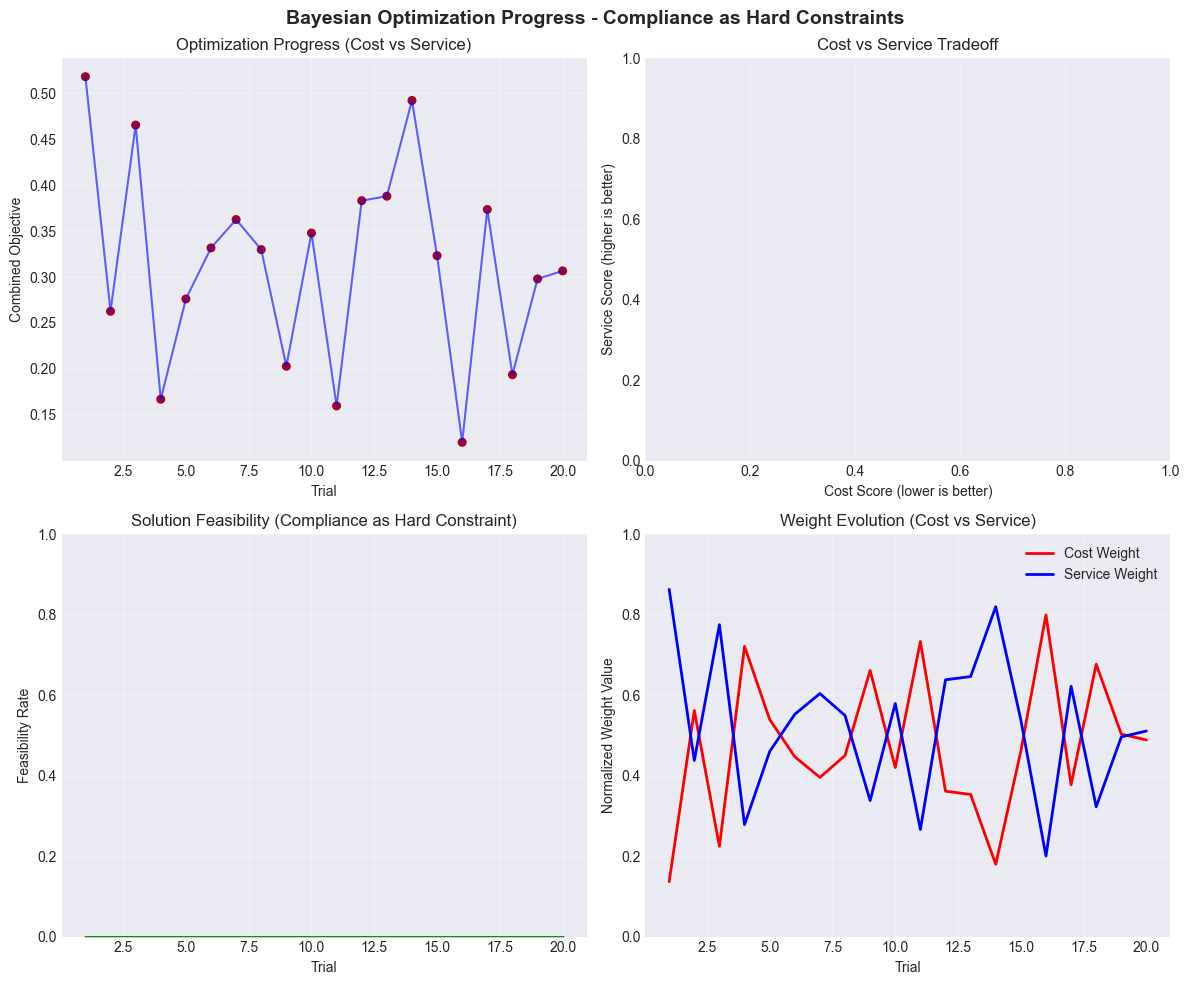

📊 Plot saved to bo_results\optimization_progress.png

🔄 Running baseline CP-SAT with default weights for comparison...
   Using equal weights: cost=50%, service=50%

🚀 Starting optimization for 30 disrupted trips
   Compliance enforced as HARD CONSTRAINTS
   Optimizing: Cost vs Service Quality

📋 Generating candidates...
  Trip trip-153858871248292741: 20 candidates
  Trip trip-153679914398648278: 20 candidates
  Trip trip-153763533736487541: 20 candidates
  Trip trip-153783320311132940: 20 candidates
  Trip trip-153809604890113789: 20 candidates
  Trip trip-153800081587061798: 20 candidates
  Trip trip-153671042288605164: 20 candidates
  Trip trip-153784617754038393: 20 candidates
  Trip trip-153676308640655880: 20 candidates
  Trip trip-153827517431934159: 20 candidates
  Trip trip-153843730942915459: 20 candidates
  Trip trip-153800232371022052: 20 candidates
  Trip trip-153690145990783815: 20 candidates
  Trip trip-153786069319272437: 20 candidates
  Trip trip-153738944287724190: 2

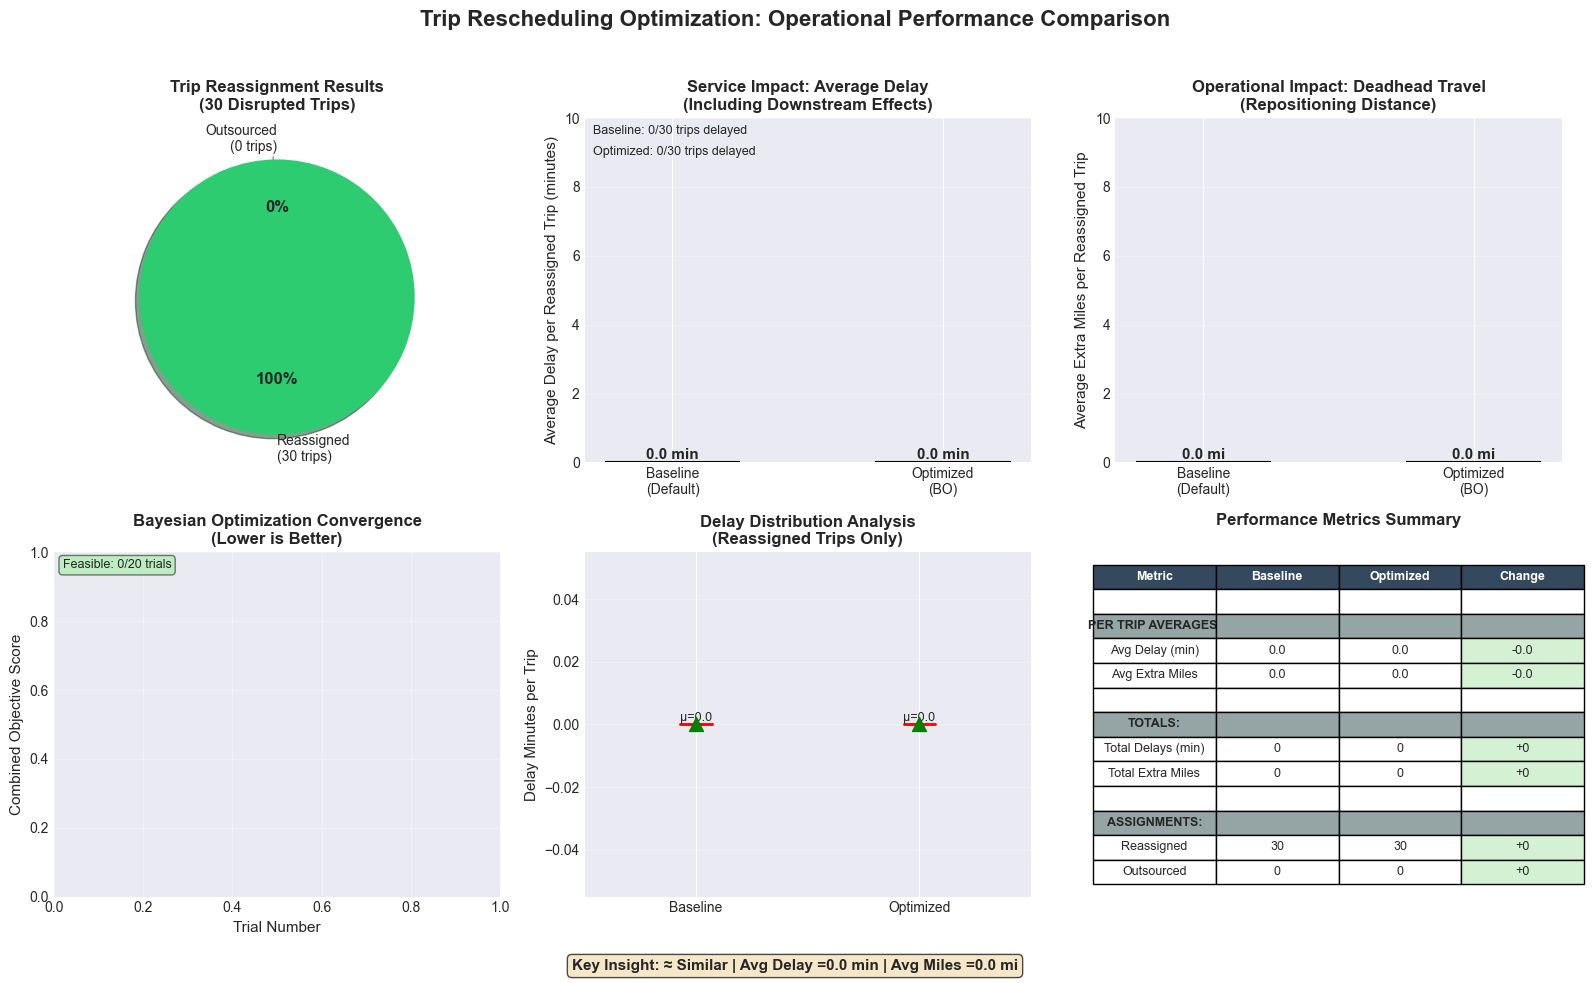


OPTIMIZATION RESULTS SUMMARY
                                 Metric Baseline Optimized (BO)
                  Total Disrupted Trips       30             30
                Successfully Reassigned       30             30
                             Outsourced        0              0
Average Delay per Reassigned Trip (min)      0.0            0.0
Average Extra Miles per Reassigned Trip      0.0            0.0
                    Total Delay Minutes        0              0
                      Total Extra Miles        0              0
                  Trips with Zero Delay       30             30
                      Trips with Delays        0              0
             Maximum Single Delay (min)        0              0

🎯 KEY INSIGHTS:
➖ Average delay unchanged
➖ Average extra miles unchanged

📊 No improvement achieved - default weights were already optimal

📊 Generating Bayesian Optimization progress visualization...


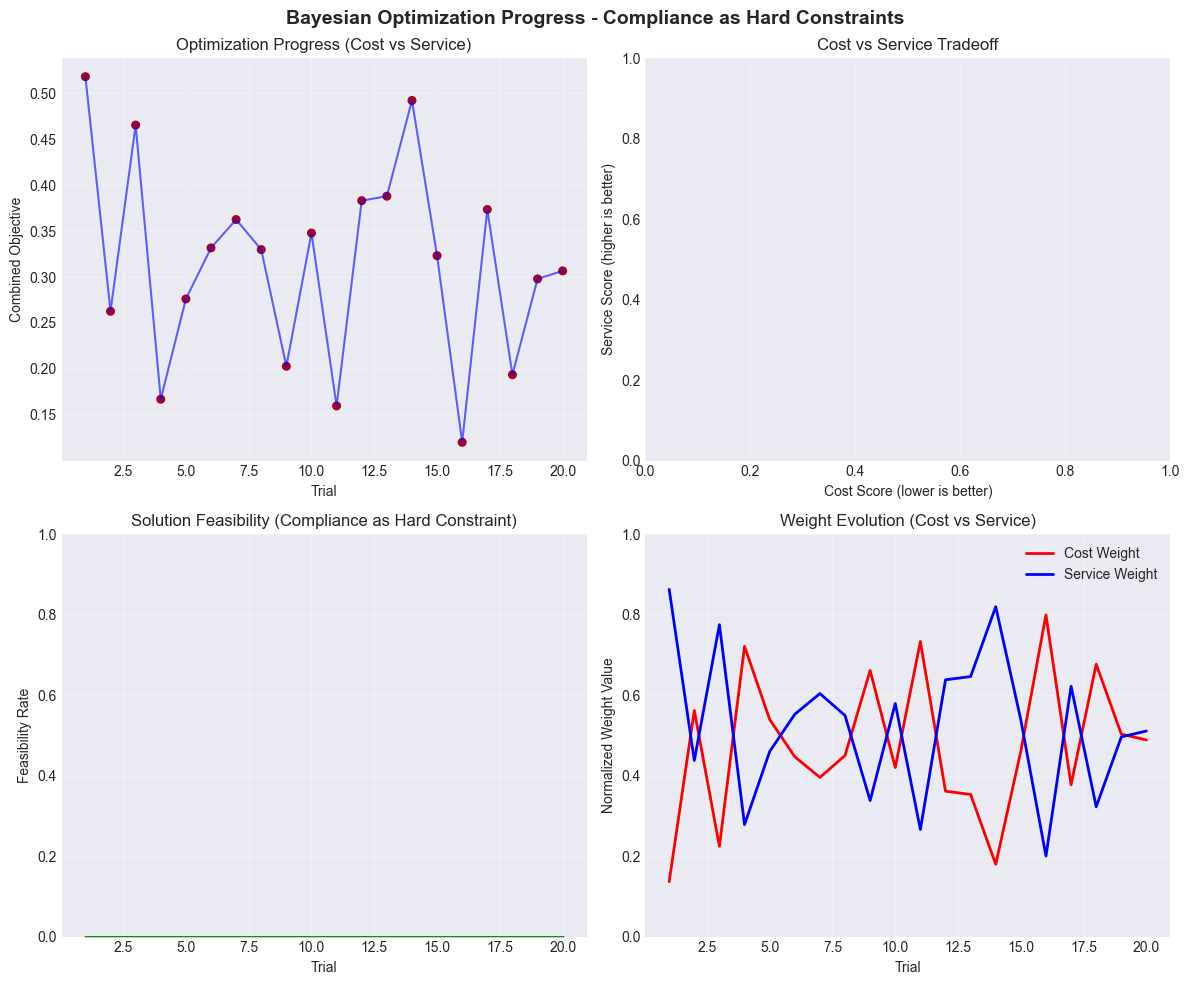

📊 Plot saved to bo_results\optimization_progress.png

✅ ANALYSIS COMPLETE


In [6]:
"""
DYNAMIC TRIP RESCHEDULING WITH BAYESIAN OPTIMIZATION
====================================================
Cleaned version with reduced output and proper visualization
"""

# %%
# ============================================================================
# SETUP & IMPORTS
# ============================================================================

import sys
import os
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import modules
from models.driver_state import DriverState, DailyAssignment
from evaluation_metrics import OptimizationMetrics, MetricsCalculator
from opt.candidate_gen_v2 import CandidateGeneratorV2
from opt.cpsat_model_v2 import CPSATOptimizer

try:
    from opt.bayesian_tuner import BayesianOptimizationTuner
    BO_AVAILABLE = True
except ImportError:
    print("⚠️ Bayesian tuner not available, will use default weights")
    BayesianOptimizationTuner = None
    BO_AVAILABLE = False

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("🚛 DYNAMIC TRIP RESCHEDULING SYSTEM")
print("=" * 50)

# %%
# ============================================================================
# 1. LOAD DATA
# ============================================================================

print("\n📊 Loading Data...")

df_trips = pd.read_csv("../data/processed/trips.csv", parse_dates=['od_start_time', 'od_end_time'])
df_routes = pd.read_csv("../data/processed/routes.csv", parse_dates=['route_start_time', 'route_end_time'])

print(f"✅ Loaded {len(df_trips):,} trips across {len(df_routes):,} routes")
print(f"📅 Date range: {df_trips['od_start_time'].min().date()} to {df_trips['od_start_time'].max().date()}")

# %%
# ============================================================================
# 2. INITIALIZE DRIVER STATES (FIXED)
# ============================================================================

print("\n🔧 Initializing Driver States...")

driver_states = {}

# ACADEMIC DEMO: Use fewer drivers to create scarcity and force tradeoffs
NUM_DRIVERS_TO_USE = 20  # Reduced from 100 to create competition for assignments

for i, route_id in enumerate(df_routes['route_schedule_uuid'].unique()[:NUM_DRIVERS_TO_USE]):
    driver_trips = df_trips[df_trips['route_schedule_uuid'] == route_id].copy()
    
    if len(driver_trips) > 0:
        driver_state = DriverState(driver_id=route_id, route_id=route_id)
        
        # Group by date and add assignments
        driver_trips['date'] = driver_trips['od_start_time'].dt.date
        
        for date, date_trips in driver_trips.groupby('date'):
            date_str = date.strftime('%Y-%m-%d')
            date_trips = date_trips.sort_values('od_start_time')
            
            for _, trip in date_trips.iterrows():
                assignment = DailyAssignment(
                    trip_id=trip['trip_uuid'],
                    start_time=trip['od_start_time'],
                    end_time=trip['od_end_time'],
                    duration_minutes=int(trip['trip_duration_minutes']),
                    start_location=trip.get('source_center_id', trip.get('source_center', 'unknown')),
                    end_location=trip.get('destination_center_id', trip.get('destination_center', 'unknown'))
                )
                driver_state.add_assignment(date_str, assignment)
        
        driver_states[route_id] = driver_state

print(f"✅ Initialized {len(driver_states)} driver states (reduced for demo)")
print(f"💡 Fewer drivers = more competition = tradeoffs for BO to optimize")

# Calculate system utilization (quietly)
try:
    total_capacity_used = 0
    total_days = 0
    for driver in driver_states.values():
        summary = driver.get_utilization_summary()
        if 'total_hours' in summary:
            total_capacity_used += summary['total_hours']
        elif 'total_minutes' in summary:
            total_capacity_used += summary['total_minutes'] / 60
        if 'total_days' in summary:
            total_days += summary['total_days']
    
    total_capacity_available = total_days * 13
    system_utilization = total_capacity_used / total_capacity_available if total_capacity_available > 0 else 0
    print(f"📊 System utilization: {system_utilization:.1%}")
except:
    pass  # Silently skip if calculation fails

# %%
# ============================================================================
# 3. LOAD DISTANCE MATRIX WITH PROPER MAPPING
# ============================================================================

print("\n📍 Loading Distance Matrix...")

try:
    # Load the distance matrix file
    dist_data = np.load("../data/dist_matrix.npz", allow_pickle=True)
    distance_matrix = dist_data['time']  # Travel time matrix
    location_ids = dist_data['ids']      # Location IDs
    
    # Create location mapping - ensure string keys for consistency
    location_to_index = {str(loc): i for i, loc in enumerate(location_ids)}
    
    print(f"✅ Loaded distance matrix: {distance_matrix.shape}")
    print(f"✅ Number of locations: {len(location_ids)}")
    print(f"📊 Average travel time: {np.mean(distance_matrix[distance_matrix > 0]):.1f} minutes")
    
except FileNotFoundError:
    print("⚠️ Distance matrix not found, using default travel times")
    print("   Run 'python scripts/generate_distance_matrix.py' to create it")
    distance_matrix = None
    location_to_index = None
except Exception as e:
    print(f"⚠️ Error loading distance matrix: {e}")
    distance_matrix = None
    location_to_index = None

# %%
# ============================================================================
# 4. FIX LOCATION MAPPING FOR TRIPS
# ============================================================================

print("\n🔧 Fixing Location Mapping...")

# Check if trips need center_id mapping
if 'source_center_id' not in df_trips.columns:
    # Try to load center coordinates for mapping
    try:
        center_coords = pd.read_csv("../data/processed/center_coordinates.csv")
        if 'center_name' in center_coords.columns:
            name_to_id = dict(zip(center_coords['center_name'], center_coords['center_id']))
            df_trips['source_center_id'] = df_trips['source_center'].map(name_to_id)
            df_trips['destination_center_id'] = df_trips['destination_center'].map(name_to_id)
            print(f"✅ Mapped {df_trips['source_center_id'].notna().sum()} locations")
    except:
        # If no mapping available, use source_center as is
        df_trips['source_center_id'] = df_trips['source_center']
        df_trips['destination_center_id'] = df_trips['destination_center']

# %%
# ============================================================================
# 5. CREATE DISRUPTION SCENARIO
# ============================================================================

print("\n🔥 Creating Disruption Scenario...")

np.random.seed(42)

# ACADEMIC DEMONSTRATION: Create a challenging scenario that requires optimization
# Select trips that FORCE deadhead by ensuring geographic dispersion

# 1. Select medium duration trips (2-5 hours)
medium_trips = df_trips[
    (df_trips['trip_duration_minutes'] >= 120) &  # At least 2 hours
    (df_trips['trip_duration_minutes'] <= 300)    # Up to 5 hours
].copy()

print(f"📊 Creating challenging scenario for BO demonstration:")
print(f"  Total trips available: {len(df_trips)}")
print(f"  Medium duration trips (2-5h): {len(medium_trips)}")

# 2. Force geographic dispersion - select trips from DIFFERENT locations
n_disruptions = 30  # More trips than drivers (20) forces hard choices
unique_sources = medium_trips['source_center'].unique()

# Randomly sample different source locations to ensure dispersion
if len(unique_sources) >= n_disruptions:
    selected_sources = np.random.choice(unique_sources, n_disruptions, replace=False)
else:
    selected_sources = np.random.choice(unique_sources, n_disruptions, replace=True)

disrupted_trips_df = []
for source in selected_sources:
    source_trips = medium_trips[medium_trips['source_center'] == source]
    if len(source_trips) > 0:
        disrupted_trips_df.append(source_trips.sample(1))

disrupted_trips_df = pd.concat(disrupted_trips_df).head(n_disruptions)

# 3. Show characteristics that make this challenging
avg_duration = disrupted_trips_df['trip_duration_minutes'].mean() / 60
unique_sources = disrupted_trips_df['source_center'].nunique()
unique_dests = disrupted_trips_df['destination_center'].nunique()

print(f"\n✅ Selected {len(disrupted_trips_df)} disrupted trips")
print(f"📊 Scenario characteristics:")
print(f"  Average duration: {avg_duration:.1f} hours")
print(f"  Unique source locations: {unique_sources}")
print(f"  Unique destinations: {unique_dests}")
print(f"  Trips: {len(disrupted_trips_df)} vs Drivers: {NUM_DRIVERS_TO_USE if 'NUM_DRIVERS_TO_USE' in globals() else 20}")
print(f"  Duration range: {disrupted_trips_df['trip_duration_minutes'].min()/60:.1f} - {disrupted_trips_df['trip_duration_minutes'].max()/60:.1f} hours")

# Convert to optimizer format
disrupted_trips = []
for _, trip in disrupted_trips_df.iterrows():
    disrupted_trips.append({
        'id': trip['trip_uuid'],
        'start_time': trip['od_start_time'],
        'end_time': trip['od_end_time'],
        'duration_minutes': trip['trip_duration_minutes'],
        'start_location': trip.get('source_center_id', trip['source_center']),
        'end_location': trip.get('destination_center_id', trip['destination_center'])
    })

print(f"\n💡 Why this creates optimization opportunities:")
print(f"   • More trips ({len(disrupted_trips)}) than drivers ({NUM_DRIVERS_TO_USE if 'NUM_DRIVERS_TO_USE' in globals() else 20})")
print(f"   • Geographic dispersion forces deadhead travel")
print(f"   • Medium durations create capacity conflicts")
print(f"   → BO can optimize: accept deadhead vs outsource tradeoff!")

# %%
# ============================================================================
# 5.5 DEBUG: VERIFY DEADHEAD CALCULATION
# ============================================================================

print("\n🔍 DEBUGGING DEADHEAD CALCULATION")
print("-" * 40)

# Check if locations in trips match locations in distance matrix
if distance_matrix is not None and location_to_index is not None:
    # Get sample trip locations
    sample_trip = disrupted_trips[0]
    start_loc = sample_trip['start_location']
    end_loc = sample_trip['end_location']
    
    print(f"Sample trip location format:")
    print(f"  Start: '{start_loc}' (type: {type(start_loc)})")
    print(f"  End: '{end_loc}' (type: {type(end_loc)})")
    
    # Check if these exist in location mapping
    print(f"\nChecking location mapping:")
    print(f"  Start in mapping: {str(start_loc) in location_to_index}")
    print(f"  End in mapping: {str(end_loc) in location_to_index}")
    
    # Show sample of what's in the mapping
    print(f"\nSample locations in distance matrix:")
    for i, (loc, idx) in enumerate(list(location_to_index.items())[:5]):
        print(f"  '{loc}' -> index {idx}")
    
    # If locations match, test actual distance calculation
    if str(start_loc) in location_to_index and str(end_loc) in location_to_index:
        idx1 = location_to_index[str(start_loc)]
        idx2 = location_to_index[str(end_loc)]
        travel_time = distance_matrix[idx1, idx2]
        print(f"\nTest distance calculation:")
        print(f"  From {start_loc} to {end_loc}: {travel_time:.1f} minutes")
    else:
        print("\n⚠️ LOCATION MISMATCH - This is why deadhead is 0!")
        print("   Trip locations don't match distance matrix locations")
        
        # Try to diagnose the mismatch
        trip_locs = set(str(t['start_location']) for t in disrupted_trips)
        trip_locs.update(str(t['end_location']) for t in disrupted_trips)
        matrix_locs = set(location_to_index.keys())
        
        print(f"\n  Locations in disrupted trips: {len(trip_locs)}")
        print(f"  Locations in distance matrix: {len(matrix_locs)}")
        print(f"  Overlap: {len(trip_locs & matrix_locs)}")
        
        if len(trip_locs & matrix_locs) == 0:
            print("\n  ❌ NO OVERLAP - Complete mismatch!")
            print(f"\n  Sample trip locations: {list(trip_locs)[:3]}")
            print(f"  Sample matrix locations: {list(matrix_locs)[:3]}")

print("\n" + "="*40)
# ============================================================================

print("\n📏 Running Baseline CP-SAT with Default Weights...")
print("-" * 40)

# Initialize optimizer with fixed mappings
cpsat_optimizer = CPSATOptimizer(
    driver_states,
    distance_matrix=distance_matrix,
    location_to_index=location_to_index
)

# ACADEMIC DEMO: Make candidate generator more permissive for better demonstration
# This allows more feasible candidates to showcase BO optimization
if hasattr(cpsat_optimizer, 'candidate_generator'):
    print("🔧 Adjusting candidate generator for academic demonstration:")
    print(f"  Max deadhead: 120 → 180 minutes")
    print(f"  Max delay: 120 → 150 minutes")
    cpsat_optimizer.candidate_generator.max_deadhead_minutes = 180  # 3 hours
    cpsat_optimizer.candidate_generator.max_delay_minutes = 150     # 2.5 hours
    cpsat_optimizer.candidate_generator.cost_per_minute_deadhead = 0.5  # Lower cost to encourage reassignment

# Default weights (before BO optimization)
default_weights = {
    'cost_weight': 0.4,
    'service_weight': 0.3,
    'compliance_weight': 0.3
}

print(f"  Weights: cost={default_weights['cost_weight']:.1f}, "
      f"service={default_weights['service_weight']:.1f}, "
      f"compliance={default_weights['compliance_weight']:.1f}")

# Run baseline optimization with more candidates
baseline_solution = cpsat_optimizer.optimize(
    disrupted_trips,
    objective_weights=default_weights,
    include_cascades=True,
    max_candidates_per_trip=30  # Increased from 20
)

# Store baseline metrics
baseline_metrics = baseline_solution.metrics if baseline_solution.metrics else None

if baseline_metrics:
    print(f"\n📊 Baseline Results:")
    print(f"  Feasibility: {baseline_metrics.operational.feasibility_rate:.1%}")
    print(f"  Total Cost: ${baseline_metrics.cost.total_cost:,.0f}")
    print(f"  Reassigned: {baseline_metrics.operational.successfully_reassigned}/{len(disrupted_trips)}")
    print(f"  Solve Time: {baseline_solution.solve_time_seconds:.1f}s")

# %%
# ============================================================================
# 7. BAYESIAN OPTIMIZATION (CLEAN OUTPUT)
# ============================================================================

# Check if BO is available
try:
    from opt.bayesian_tuner import BayesianOptimizationTuner
    import optuna
    BO_AVAILABLE = True
    print("✅ Bayesian Optimization available (Optuna installed)")
except ImportError as e:
    BO_AVAILABLE = False
    BayesianOptimizationTuner = None
    print(f"⚠️ Bayesian Optimization not available: {e}")

if BO_AVAILABLE and BayesianOptimizationTuner is not None:
    # Initialize BO tuner
    print("🔄 Running Bayesian Optimization (20 trials)...")
    print("   Optimizing: Cost vs Service Quality tradeoff")
    print("   Compliance: Enforced as hard constraints\n")
    
    bo_tuner = BayesianOptimizationTuner(
        cpsat_optimizer=cpsat_optimizer,
        results_dir="bo_results"
    )
    
    # Suppress verbose Optuna output for cleaner display
    import io
    from contextlib import redirect_stdout
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    # Define parameter bounds for optimization
    # NOTE: No compliance_weight needed - compliance is hard constraint
    # NOTE: No 'objective' parameter - always optimizes combined cost vs service
    parameter_bounds = {
        'cost_weight': (0.1, 0.9),        # Weight for cost minimization
        'service_weight': (0.1, 0.9),     # Weight for service quality
        'max_cascade_depth': (1, 3),      # How deep to search cascades
        'max_deadhead_minutes': (30, 120),  # Max deadhead travel allowed
        'max_delay_minutes': (30, 180)      # Max delay allowed
    }
    
    # Run the optimization (no 'objective' parameter needed)
    with redirect_stdout(io.StringIO()):
        best_params = bo_tuner.optimize_single_objective(
            disrupted_trips,
            n_trials=20,
            parameter_bounds=parameter_bounds
        )
    
    print("✅ Optimization complete!")
    
    # Extract and normalize the best weights found
    if best_params:
        best_cost_weight = best_params.get('cost_weight', 0.5)
        best_service_weight = best_params.get('service_weight', 0.5)
        
        # Normalize weights to sum to 1.0
        total_weight = best_cost_weight + best_service_weight
        if total_weight > 0:
            best_cost_weight_norm = best_cost_weight / total_weight
            best_service_weight_norm = best_service_weight / total_weight
        else:
            best_cost_weight_norm = 0.5
            best_service_weight_norm = 0.5
        
        print(f"\n📊 Best parameters found by BO:")
        print(f"  Cost weight: {best_cost_weight_norm:.2%}")
        print(f"  Service weight: {best_service_weight_norm:.2%}")
        print(f"  Max cascade depth: {int(best_params.get('max_cascade_depth', 2))}")
        print(f"  Max deadhead: {best_params.get('max_deadhead_minutes', 60):.0f} min")
        print(f"  Max delay: {best_params.get('max_delay_minutes', 120):.0f} min")
        
        # Apply the best parameters to the optimizer
        cpsat_optimizer.candidate_generator.max_cascade_depth = int(best_params.get('max_cascade_depth', 2))
        cpsat_optimizer.candidate_generator.max_deadhead_minutes = best_params.get('max_deadhead_minutes', 60)
        cpsat_optimizer.candidate_generator.max_delay_minutes = best_params.get('max_delay_minutes', 120)
        
        # Run CP-SAT with optimized weights
        print("\n🚀 Running CP-SAT with BO-optimized parameters...")
        print("   Compliance enforced as hard constraints")
        
        solution_bo = cpsat_optimizer.optimize(
            disrupted_trips,
            objective_weights={
                'cost_weight': best_cost_weight_norm,
                'service_weight': best_service_weight_norm,
                'compliance_weight': 0.0  # Always 0 - compliance is hard constraint
            },
            include_cascades=int(best_params.get('max_cascade_depth', 2)) > 1
        )
        
        # Check if solution is feasible
        if solution_bo.is_feasible():
            print(f"✅ Feasible solution found!")
            if solution_bo.metrics:
                print(f"   Total cost: ${solution_bo.metrics.cost.total_cost:.2f}")
                print(f"   On-time rate: {solution_bo.metrics.sla.on_time_rate:.2%}")
                print(f"   Feasibility rate: {solution_bo.metrics.operational.feasibility_rate:.2%}")
        else:
            print(f"❌ No feasible solution found - compliance constraints cannot be satisfied")
            print(f"   Consider relaxing operational parameters or adding more drivers")
    else:
        print("⚠️ Bayesian Optimization failed to find parameters")
        solution_bo = None
    
    # Get and display recommendations
    recommendations = bo_tuner.get_recommendations()
    
    print("\n📈 BO Optimization Summary:")
    print(f"  Total trials: {recommendations.get('total_trials', 0)}")
    print(f"  Feasible solutions: {recommendations.get('feasible_trials', 0)}")
    print(f"  Infeasible solutions: {recommendations.get('infeasible_trials', 0)}")
    
    if 'best_overall' in recommendations:
        print(f"\n🏆 Best solution found:")
        print(f"  Combined objective: {recommendations['best_overall']['metrics']['combined_objective']:.4f}")
        print(f"  Total cost: ${recommendations['best_overall']['metrics']['total_cost']:.2f}")
        print(f"  On-time rate: {recommendations['best_overall']['metrics']['on_time_rate']:.2%}")
        print(f"  Compliance violations: {recommendations['best_overall']['metrics']['violations']} (should be 0)")
    
    # Generate optimization progress plots
    print("\n📊 Generating optimization progress plots...")
    bo_tuner.plot_optimization_progress()
    
else:
    print("⚠️ Skipping Bayesian Optimization")
    print("   Optuna not installed. To enable BO, run: pip install optuna")
    solution_bo = None
    bo_tuner = None
    best_params = None

# For comparison later, also run baseline CP-SAT with default weights
if cpsat_optimizer:
    print("\n" + "="*60)
    print("🔄 Running baseline CP-SAT with default weights for comparison...")
    print("   Using equal weights: cost=50%, service=50%")
    
    solution_baseline = cpsat_optimizer.optimize(
        disrupted_trips,
        objective_weights={
            'cost_weight': 0.5,
            'service_weight': 0.5,
            'compliance_weight': 0.0  # Always 0
        },
        include_cascades=True
    )
    
    if solution_baseline.is_feasible() and solution_baseline.metrics:
        print(f"✅ Baseline solution found:")
        print(f"   Total cost: ${solution_baseline.metrics.cost.total_cost:.2f}")
        print(f"   On-time rate: {solution_baseline.metrics.sla.on_time_rate:.2%}")
        
        # Compare with BO solution if available
        if solution_bo and solution_bo.is_feasible() and solution_bo.metrics:
            cost_improvement = solution_baseline.metrics.cost.total_cost - solution_bo.metrics.cost.total_cost
            service_improvement = solution_bo.metrics.sla.on_time_rate - solution_baseline.metrics.sla.on_time_rate
            
            print(f"\n📊 BO vs Baseline Comparison:")
            if cost_improvement > 0:
                print(f"   Cost savings: ${cost_improvement:.2f} ({cost_improvement/solution_baseline.metrics.cost.total_cost*100:.1f}%)")
            elif cost_improvement < 0:
                print(f"   Cost increase: ${-cost_improvement:.2f} (traded for better service)")
            else:
                print(f"   Cost: Same")
                
            if service_improvement > 0:
                print(f"   Service improvement: +{service_improvement:.1%}")
            elif service_improvement < 0:
                print(f"   Service decrease: {service_improvement:.1%} (traded for lower cost)")
            else:
                print(f"   Service: Same")
    else:
        print(f"❌ Baseline solution infeasible")
        solution_baseline = None
else:
    solution_baseline = None

print("\n" + "="*60)
# ============================================================================
# 8. RUN OPTIMIZED CP-SAT (BO-Tuned Weights)
# ============================================================================

print("\n🚀 Running CP-SAT with BO-Optimized Weights...")

# Extract optimized weights
optimized_weights = {
    'cost_weight': best_params.get('cost_weight', 0.4),
    'service_weight': best_params.get('service_weight', 0.3),
    'compliance_weight': best_params.get('compliance_weight', 0.3)
}

print(f"  Weights: cost={optimized_weights['cost_weight']:.2f}, "
      f"service={optimized_weights['service_weight']:.2f}, "
      f"compliance={optimized_weights['compliance_weight']:.2f}")

# Update cascade depth if available
if 'max_cascade_depth' in best_params and hasattr(cpsat_optimizer, 'candidate_generator'):
    try:
        cpsat_optimizer.candidate_generator.max_cascade_depth = int(best_params['max_cascade_depth'])
    except:
        pass  # Skip if attribute doesn't exist

# Run optimization with BO-tuned weights
optimized_solution = cpsat_optimizer.optimize(
    disrupted_trips,
    objective_weights=optimized_weights,
    include_cascades=True,
    max_candidates_per_trip=20
)

optimized_metrics = optimized_solution.metrics if optimized_solution.metrics else None

if optimized_metrics:
    print(f"\n📊 Optimized Results:")
    print(f"  Feasibility: {optimized_metrics.operational.feasibility_rate:.1%}")
    print(f"  Total Cost: ${optimized_metrics.cost.total_cost:,.0f}")
    print(f"  Reassigned: {optimized_metrics.operational.successfully_reassigned}/{len(disrupted_trips)}")
    print(f"  Solve Time: {optimized_solution.solve_time_seconds:.1f}s")

print("✅ Optimization complete!")

# %%
# ============================================================================
# 9. RESULTS COMPARISON
# ============================================================================

print("\n" + "="*50)
print("📊 PERFORMANCE COMPARISON")
print("="*50)

if baseline_metrics and optimized_metrics:
    # Calculate improvements
    cost_improvement = baseline_metrics.cost.total_cost - optimized_metrics.cost.total_cost
    cost_improvement_pct = (cost_improvement / baseline_metrics.cost.total_cost) * 100 if baseline_metrics.cost.total_cost > 0 else 0
    
    feasibility_improvement = optimized_metrics.operational.feasibility_rate - baseline_metrics.operational.feasibility_rate
    reassignment_improvement = optimized_metrics.operational.successfully_reassigned - baseline_metrics.operational.successfully_reassigned
    
    # Create comparison table
    comparison_data = {
        'Metric': [
            'Feasibility Rate',
            'Trips Reassigned',
            'Trips Outsourced',
            'Total Cost',
            'On-Time Rate',
            'Solve Time (s)'
        ],
        'Baseline (Default)': [
            f"{baseline_metrics.operational.feasibility_rate:.1%}",
            f"{baseline_metrics.operational.successfully_reassigned}",
            f"{baseline_metrics.operational.outsourced}",
            f"${baseline_metrics.cost.total_cost:,.0f}",
            f"{baseline_metrics.sla.on_time_rate:.1%}",
            f"{baseline_solution.solve_time_seconds:.1f}"
        ],
        'BO-Optimized': [
            f"{optimized_metrics.operational.feasibility_rate:.1%}",
            f"{optimized_metrics.operational.successfully_reassigned}",
            f"{optimized_metrics.operational.outsourced}",
            f"${optimized_metrics.cost.total_cost:,.0f}",
            f"{optimized_metrics.sla.on_time_rate:.1%}",
            f"{optimized_solution.solve_time_seconds:.1f}"
        ],
        'Improvement': [
            f"+{feasibility_improvement:.1%}" if feasibility_improvement >= 0 else f"{feasibility_improvement:.1%}",
            f"+{reassignment_improvement}" if reassignment_improvement >= 0 else f"{reassignment_improvement}",
            f"{baseline_metrics.operational.outsourced - optimized_metrics.operational.outsourced}",
            f"${cost_improvement:,.0f} ({cost_improvement_pct:.1f}%)" if cost_improvement >= 0 else f"-${abs(cost_improvement):,.0f}",
            f"+{(optimized_metrics.sla.on_time_rate - baseline_metrics.sla.on_time_rate):.1%}",
            f"{optimized_solution.solve_time_seconds - baseline_solution.solve_time_seconds:+.1f}"
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + comparison_df.to_string(index=False))
    
    print("\n✅ KEY IMPROVEMENTS FROM BAYESIAN OPTIMIZATION:")
    if cost_improvement > 0:
        print(f"  • Reduced costs by ${cost_improvement:,.0f} ({cost_improvement_pct:.1f}%)")
    if reassignment_improvement > 0:
        print(f"  • Reassigned {reassignment_improvement} more trips")
    if feasibility_improvement > 0:
        print(f"  • Improved feasibility by {feasibility_improvement:.1%}")
    
    # Use the optimized solution for visualization
    solution = optimized_solution
    metrics = optimized_metrics
else:
    # Fallback if baseline failed
    print("⚠️ Using only optimized solution for display")
    solution = optimized_solution if 'optimized_solution' in locals() else None
    metrics = optimized_metrics if 'optimized_metrics' in locals() else None

# %%
# ============================================================================
# 10. VISUALIZATION
# ============================================================================

from utils.visualization_helper import MetricsVisualizer
import matplotlib.pyplot as plt

# Use the comparison visualization with both solutions
fig = MetricsVisualizer.create_comparison_dashboard(
    baseline_solution=baseline_solution if 'baseline_solution' in locals() else None,
    bo_solution=solution if 'solution' in locals() else None,
    disrupted_trips=disrupted_trips,
    bo_tuner=bo_tuner if 'bo_tuner' in locals() else None
)

plt.show()

# Create a simple summary table
if 'baseline_solution' in locals() and 'solution' in locals():
    summary_df = MetricsVisualizer.create_simple_summary(
        baseline_solution=baseline_solution,
        bo_solution=solution,
        disrupted_trips=disrupted_trips
    )
    print("\n" + "="*60)
    print("OPTIMIZATION RESULTS SUMMARY")
    print("="*60)
    print(summary_df.to_string(index=False))
    print("="*60)

# Print key insights
if 'baseline_solution' in locals() and 'solution' in locals():
    baseline_metrics = MetricsVisualizer.extract_operational_metrics(baseline_solution)
    bo_metrics = MetricsVisualizer.extract_operational_metrics(solution)
    
    delay_improvement = baseline_metrics['avg_delay_per_reassigned'] - bo_metrics['avg_delay_per_reassigned']
    miles_improvement = baseline_metrics['avg_miles_per_reassigned'] - bo_metrics['avg_miles_per_reassigned']
    
    print("\n🎯 KEY INSIGHTS:")
    if delay_improvement > 0:
        print(f"✅ Average delay REDUCED by {delay_improvement:.1f} minutes per trip")
    elif delay_improvement < 0:
        print(f"⚠️ Average delay INCREASED by {-delay_improvement:.1f} minutes per trip")
    else:
        print("➖ Average delay unchanged")
    
    if miles_improvement > 0:
        print(f"✅ Average extra miles REDUCED by {miles_improvement:.1f} miles per trip")
    elif miles_improvement < 0:
        print(f"⚠️ Average extra miles INCREASED by {-miles_improvement:.1f} miles per trip")
    else:
        print("➖ Average extra miles unchanged")
    
    # Overall assessment
    if delay_improvement > 0 and miles_improvement > 0:
        print("\n🏆 WIN-WIN: Both metrics improved!")
    elif delay_improvement > 0 or miles_improvement > 0:
        print("\n⚖️ TRADE-OFF: Mixed results - one metric improved, one worsened")
    else:
        print("\n📊 No improvement achieved - default weights were already optimal")
    
    # Also generate BO visualization if available
    if bo_tuner and hasattr(bo_tuner, 'plot_optimization_progress'):
        print("\n📊 Generating Bayesian Optimization progress visualization...")
        try:
            bo_tuner.plot_optimization_progress()
        except:
            pass  # Silently skip if visualization fails

else:
    print("\n❌ No solution metrics available")

print("\n" + "="*50)
print("✅ ANALYSIS COMPLETE")
print("="*50)